## Epidemiology model for spread of infectious diasease


In this code I will use a SIR (susceptible-infected-removed) model. The model traces the evolution of a susceptible population $S$, infected $I$, and removed population, $R$. The equations are


\begin{eqnarray}
\frac{dS}{dt} &=&-\beta I S \\
\frac{dI}{dt} &=& \beta I S - \gamma I\\
\frac{dR}{dt} &=&\gamma I
\end{eqnarray}


$\beta$ is the infection rate and $\gamma$ is the recovery rate. 

Contact with infected people removes a fraction of the susceptible population at the rate $\beta I S $, placing them at the infected population. At the same time, the infected population has a recovery rate $\gamma$. A number $\gamma I$ is removed from the infected and placed in the removed population. 


### The parameter $R_0$

We can gain understanding of the dynamics of the infected population by writing its equation as 

\begin{equation}
\frac{dI}{dt} = \gamma I \left(\frac{\beta}{\gamma} S - 1 \right),
\end{equation}

and noticing that in the beggining of the infection, when $S \approx 1$ (the populations are normalized by $N=S+I+R$ where $N$ is the size of the population) it reduces to 

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(\frac{\beta}{\gamma}  - 1 \right).
\end{equation}

The dynamics of the infected population is controled by the parameter 

\begin{equation}
R_0 = \frac{\beta}{\gamma}
\end{equation}

When $R_0 > 1$ the infected population grows exponentially. When $R_0 \leq 1$ the disease is controlled. 

$R_0$ can be thought of as the average number of people an infected person will contaminate before being removed. As such, it is called the basic reproduction number. Social distancing has the effect of lowering the infection rate $\beta$, and thus the basic reproduction number $R_0$. 






### Doubling time and application to current COVID-19 epidemics

Based on  

\begin{equation}
\frac{dI}{dt} \approx \gamma I \left(R_0  - 1 \right)
\end{equation}

we can relate the doubling time of the infection to $R_0$. The e-folding time is 

\begin{equation}
t_e = \frac{1}{\gamma \left(R_0-1\right)}
\end{equation}

So the doubing time is 

\begin{equation}
t_{\rm double} = t_e \ \ln 2 = \frac{\ln 2}{\gamma \left(R_0-1\right)}
\end{equation}

Data from China and S. Korea imply that the recovery rate is $\gamma=0.06$. As such, the doubling time and $R_0$ are related by the graph below. Also shown are the doubling rate of China, South Korea, Italy, and the USA, as of March 14th, 2020. 


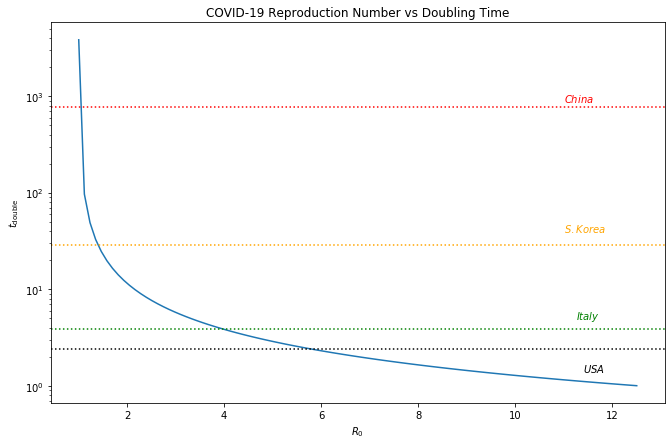

In [1]:
import numpy as np
import pylab as plt
import sys 

#
# R0 vs doubling time 
#

gamma = 0.06
mu = 0.01 
R0=np.linspace(1.003,12.5,100)
doubling_time = np.log(2.)/(gamma*(R0-1))
plt.figure(figsize=(11,7))

plt.plot(R0,doubling_time)

#
# Doubling time estimates as of March 14th.
#

plt.axhline(2.4,linestyle=':',color='black')
plt.axhline(3.9,linestyle=':',color='green')
plt.axhline(29,linestyle=':',color='orange')
plt.axhline(770,linestyle=':',color='red')

plt.annotate('$USA$'     ,xy=(11.4,2.4-1),color='black')
plt.annotate('$Italy$'   ,xy=(11.25,3.9+1),color='green')
plt.annotate('$S. Korea$',xy=(11.0,29+10) ,color='orange')
plt.annotate('$China$'   ,xy=(11.0,770+100),color='red')

plt.title("COVID-19 Reproduction Number vs Doubling Time")
plt.ylabel("$t_{\mathrm{double}}$")
plt.xlabel("$R_0$")
plt.yscale('log')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes                   
plt.rc('axes', titlesize=MEDIUM_SIZE) # fontsize of the axes title               
plt.rc('axes', labelsize=BIGGER_SIZE) # fontsize of the x and y labels           
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels             
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize                         
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title         

#plt.show()
plt.savefig("R0DT_031520.png")



### Death rate 

The last parameter in the model is the death rate. The removed are either recovered/cured (C) or dead (D), according to 

\begin{eqnarray}
C &=& (1-\mu) R \\
D &=& \mu R 
\end{eqnarray}

where $\mu$ is the death rate. The cured are supposed to have gained immunity and not added again to the susceptible population. Current knowledge of the epidemic seem to imply $\mu$=0.01. 

### Model applied to the current epidemics 

Given a universal $\gamma=0.06$, the model input are the doubling times $t_{\rm double}$ and the initial number of infected $I_0$. Below are the numbers of March 14th for Italy, S. Korea, China, and the USA. The total population is for normalization purposes only. The model assumes N=1 and works with population fractions instead.  



The next blocks have funtion definitions

In [2]:
def date_to_time(d):
    from datetime import datetime    

    n=len(d)    
    
    date=np.zeros(n)
    for i in range(n):
        date_object = datetime.strptime(d[i], '%y-%m-%d') 
        date[i] = datetime.fromisoformat(np.str(date_object)).timestamp()
                  
    return (date-date[n-1])/86400.                
    
    
def calc_doubling_data(time,cases):
    
    tmp = np.gradient(np.log(cases),time) 
    # get the average slope of the past week
    n = len(time)
    ksi = np.mean(tmp[n-8:n-1])
    doubling_time = np.log(2.)/ksi
    
    return doubling_time
    
def select_country(name):

    if (name == 'Italy'):
        N=6e7  
        dates = ['20-01-31','20-02-06','20-02-21','20-02-22','20-02-23','20-02-24','20-02-25','20-02-26','20-02-27','20-02-28','20-02-29','20-03-1','20-03-2','20-03-3','20-03-4','20-03-5','20-03-6','20-03-7','20-03-8','20-03-9','20-03-10','20-03-11','20-03-12','20-03-13','20-03-14','20-03-15','20-03-16']
        data  = [2,3,20,79,150,227,320,445,650,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,15113,17660,21157,24747,27980] 
        death = [0,0,1,2,3,6,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,1016,1266,1441,1809,2158]
        #doubling_time=3.9 
        # alpha = 0.615384615385
    elif (name== "S. Korea"):
        N=5e7
        dates = ['20-01-20','20-01-24','20-01-25','20-01-26','20-01-27','20-01-30','20-01-31','20-02-1','20-02-2','20-02-3','20-02-4','20-02-5','20-02-6','20-02-7','20-02-8','20-02-9','20-02-10','20-02-11','20-02-16','20-02-17','20-02-18','20-02-19','20-02-20','20-02-21','20-02-22','20-02-23','20-02-24','20-02-25','20-02-26','20-02-27','20-02-28','20-02-29','20-03-1','20-03-2','20-03-3','20-03-4','20-03-5','20-03-6','20-03-7','20-03-8','20-03-9','20-03-10','20-03-11','20-03-12','20-03-13','20-03-14','20-03-15','20-03-16']
        data = [1,2,2,3,4,6,11,12,15,15,16,19,23,24,24,27,27,28,29,30,31,51,104,204,433,602,833,977,1261,1766,2337,3150,4212,4812,5328,5766,6284,6767,7134,7382,7513,7755,7869,7979,8086,8162,8236,8320]
        print('S. Korea')
        print(len(dates))
        print(len(data))
        #doubling_time=29
        # alpha = 0.0827586206897
    elif (name=="China"):
        N=1.4e9
        dates=['20-01-16','20-01-17','20-01-18','20-01-19','20-01-20','20-01-21','20-01-22','20-01-23','20-01-24','20-01-25','20-01-26','20-01-27','20-01-28','20-01-29','20-01-30','20-01-31','20-02-1','20-02-2','20-02-3','20-02-4','20-02-5','20-02-6','20-02-7','20-02-8','20-02-9','20-02-10','20-02-11','20-02-12','20-02-13','20-02-14','20-02-15','20-02-16','20-02-17','20-02-18','20-02-19','20-02-20','20-02-21','20-02-22','20-02-23','20-02-24','20-02-25','20-02-26','20-02-27','20-02-28','20-02-29','20-03-1','20-03-2','20-03-3','20-03-4','20-03-5','20-03-6','20-03-7','20-03-8','20-03-9','20-03-10','20-03-11','20-03-12','20-03-13','20-03-14','20-03-15','20-03-16']
        data =[45,62,121,198,291,440,571,830,1287,1975,2744,4515,5974,7711,9692,11791,14380,17205,20438,24324,28018,31161,34546,37198,40171,42638,44653,46472,48467,49970,51091,70548,72436,74185,75002,75891,76288,76936,77150,77658,78064,78497,78824,79251,79824,80026,80151,80270,80409,80552,80651,80695,80735,80754,80778,80793,80813,80824,80844,80860,80881]
        #doubling_time=770.
        # alpha=0.00311688311688
    elif (name=="USA"):
        N=3.2e8
        dates = ['20-01-21','20-01-24','20-01-25','20-01-26','20-01-30','20-02-01','20-02-02','20-02-05','20-02-20','20-02-26','20-02-27','20-02-28','20-02-29','20-03-1','20-03-2','20-03-3','20-03-4','20-03-5','20-03-6','20-03-7','20-03-8','20-03-9','20-03-10','20-03-11','20-03-12','20-03-13','20-03-14','20-03-15','20-03-16']
        data  = [1,2,3,5,6,7,8,11,12,14,15,19,24,42,57,85,111,175,252,352,495,643,932,1203,1598,2160,2827,3494,4600]
        #doubling_time=2.4
        # alpha = 1.0 # effect of quanrentine -- how to model it
        # doubling_time=2.4 / alpha
    elif (name=="Sweden"):
        N=1e7
        dates = ['20-01-31','20-02-26','20-02-27','20-02-28','20-02-29','20-03-1','20-03-2','20-03-3','20-03-4','20-03-5','20-03-6','20-03-7','20-03-8','20-03-9','20-03-10','20-03-11','20-03-12','20-03-13','20-03-14','20-03-15','20-03-16']
        data  = [1,2,7,11,13,14,15,30,52,94,137,161,203,260,356,500,687,814,941,1032,1121]
        #doubling_time=2.9
    elif (name=="Brazil"):
        N=2e8
        dates = ['20-02-25','20-02-29','20-03-4','20-03-5','20-03-6','20-03-7','20-03-8','20-03-9','20-03-10','20-03-11','20-03-12','20-03-13','20-03-14','20-03-15','20-03-16']
        data  = [1,2,4,8,13,19,25,30,34,52,77,98,121,200,234]
        #doubling_time=calc_doubling_data(dates,data)
    #elif (name=="USA with Korea R0"):
    #    N=3.2e8
    #    dates = ['20-01-21','20-01-24','20-01-25','20-01-26','20-01-30','20-02-01','20-02-02','20-02-05','20-02-20','20-02-26','20-02-27','20-02-28','20-02-29','20-03-1','20-03-2','20-03-3','20-03-4','20-03-5','20-03-6','20-03-7','20-03-8','20-03-9','20-03-10','20-03-11','20-03-12','20-03-13','20-03-14','20-03-15','20-03-16']
    #    data  = [1,2,3,5,6,7,8,11,12,14,15,19,24,42,57,85,111,175,252,352,495,643,932,1203,1598,2160,2827,3494,4600]
    #    #doubling_time=29
    #    # alpha = 1.0 # effect of quarentine -- how to model it
    #    # doubling_time=2.4 / alpha
    else:
        print("choose a valid country")
        sys.exit()
        
        
    cases=np.array(data)
    I0=cases[len(cases)-1]
    days_past=date_to_time(dates)    
    doubling_time=calc_doubling_data(days_past,cases)    
    beta = gamma + np.log(2.)/doubling_time 
    R0 = beta/gamma

    country = dict([('name', name),
                    ('beta', beta),
                    ('gamma', gamma),
                    ('I0',I0),
                    ('N',N),
                    ('R0',R0),
                    ('days past',days_past),
                    ('cases',cases),
                    ('doubling time',doubling_time)])

    print("Parameters for:",country['name'])
    print(f'Basic reproduction number R0 = {R0:.1f}')
    print("Doubling time =",doubling_time," days")
    print(f'Infection rate beta = {beta:.2f}')
    print('Current cummulative infections=',I0)

    return country


In [3]:
def appendvalues(S,I,R,t,SS,II,RR,tt):
    SS.append(S)
    II.append(I)
    RR.append(R)
    tt.append(t)
    return SS,II,RR,tt

def RK3(f):
    beta  = f['beta']
    gamma = f['gamma']
    I0    = f['I0']
    R0    = f['R0']
    N     = f['N']
    dbt   = f['doubling time']
    
    alpha_ts   = np.double([0.   , -5./9.  ,-153./128.])
    beta_ts    = np.double([1./3., 15./16. ,   8./15. ])
    Cdt = 0.5
#
#  Timestep defined by the timescale given by the rate of infection 
#
    tau_beta  = 1/beta 
    dt = Cdt*tau_beta
#    
# End of epidemics. 100 days if the doubling time is less than 10 days, 
# and 540 days (18 months) otherwise, which is the time estimated to
# develop a vaccine. 
#
    if (dbt < 10.):
        tmax = 100.
    else:
        tmax = 540.
#
# Lists to store the populations 
#
    SS=[]  # susceptible
    II=[]  # infected
    RR=[]  # removed
    DD=[]  # dead
    tt=[]  # time

#
# Initial values. 
#
    I=I0/N
    R=0.
    S=1-I
#
    dSdt=0.
    dIdt=0.
    dRdt=0.

#  Start the integration
    itmax=100000    
    t=0.
    ds=0.
    SS,II,RR,tt = appendvalues(S,I,R,t,SS,II,RR,tt)
#
    for it in np.arange(itmax):
#                                                                                
        dt_beta_ts = [i * dt for i in beta_ts]
#                                                                                
        for itsub in np.arange(0,2):
            dSdt   = alpha_ts[itsub]*dSdt
            dIdt   = alpha_ts[itsub]*dIdt
            dRdt   = alpha_ts[itsub]*dRdt
            ds     = alpha_ts[itsub]*ds
#                                                                                
            dSdt = dSdt - beta*I*S 
            dIdt = dIdt + beta*I*S - gamma*I
            dRdt = dRdt + gamma*I
            ds   = ds   + 1.    
        
            S = S + dt_beta_ts[itsub]*dSdt
            I = I + dt_beta_ts[itsub]*dIdt
            R = R + dt_beta_ts[itsub]*dRdt
            t = t + dt_beta_ts[itsub]*ds

        SS,II,RR,tt = appendvalues(S,I,R,t,SS,II,RR,tt)
    
        if ((it == itmax) or t > tmax):
            print(f'End of simulation at t = {np.int(t):d} days \n')
            #
            #  Separate the removed into recovered and dead according to death rate
            #
            C=(1-mu)*R
            D=mu*R
        
            print('Percentage of people who avoided infection, S=',np.int(np.round(100*S)),'%')       
            print('Percentage of infected, I=',np.int(np.round(100*I)),'%')    
            print('Percentage of removed, R=',np.int(np.round(100*R)),'%\n')
        
            print('Percentage infected at peak of epidemics: ',np.int(np.round(100*np.array(II).max())),'% \n')    
            print(f'Total number of deaths = {np.int(np.round(D*N)):d}')

            break
            
    results = dict([('Susceptible', SS), ('Infected', II), ('Removed', RR),('Time',tt)])
        
    return results

In [4]:
def plottage(country,results):

    t=np.array(results['Time'])
    S=np.array(results['Susceptible'])
    R=np.array(results['Removed'])
    I=np.array(results['Infected'])
    N=country['N']
    I0=I[0]*N
    R0=country['R0']
    gamma=country['gamma']
    dbt = country['doubling time']
    days_past = country['days past']
    
    C=(1-mu)*R
    D=mu*R

    fig, ((ax1,ax2)) = plt.subplots(1,2,figsize=[16,5])

# Evolution of the populations

    ax1.plot(t,100*S,color='green',label='Susceptible')
    ax1.plot(t,100*I,color='orange',label='Infected')
    ax1.plot(t,100*C,color='blue',label='Recovered')
    ax1.plot(t,100*D,color='black',label='Dead')

# Cumulative number of infections and deaths 

    ax2.plot(t,N*(1-S),color='orange',label='Infections')
    ax2.plot(t,N*D,color='black',label='Deaths')

    ax2.plot(days_past,country['cases'],'o',color='orange')
    #plt.plot(time,cases[n-1]*np.exp(ksi*time))    
    #plt.yscale('log')
    
# Overplot the initial exponential rate

    strdbt = np.str(np.int(dbt))+'.'+np.str(np.int(10*(dbt-np.int(dbt))))
    label='Doubling Time = '+strdbt+' days'
    ax2.plot(t,I0*np.exp(gamma*(R0-1)*t),color='purple',linestyle='--',label=label)

# Annotations and prettifying 

    ax1.set_xlabel("Days")
    ax1.set_ylabel("Percentage of Population (%)")
    ax1.legend()
    ax1.set_xlim([0,t.max()])
    strR0 = np.str(np.int(R0))+'.'+np.str(np.int(10*(R0-np.int(R0))))
    title=country['name']+", $\gamma=0.06,R_0=$"+strR0
    ax1.set_title(title)
    ax1.grid()

    ax2.set_yscale("log")
    ax2.set_ylim([1,1.5*N])
    ax2.set_xlim([days_past.min(),t.max()])
    ax2.set_xlabel("Days")
    ax2.set_ylabel("Cummulative # of Cases")
    char = np.int(np.log10(N))
    mant = np.int(np.round(10**(np.log10(N)-char)))
    strlog = np.str(mant)+' x 10$^'+np.str(char)+'$'
    title=country['name']+", $N$="+strlog+", $I_0$="+np.str(np.int(I0))
    ax2.set_title(title)
    ax2.legend()
    ax2.grid()

    plt.savefig(country['name']+"_population_031520.png")

    return 

### Integration

We now solve the system of differential equations with a Runge-Kutta algorithm. The timescales of the model are the infection time, given by the inverse of the infection rate 

\begin{equation}
\tau_\beta = \frac{1}{\beta}
\end{equation}

and the inverse of the recovery rate, which is the timescale of the duration of the epidemics.  

\begin{equation}
\tau_\gamma = \frac{1}{\gamma}
\end{equation}

We take timesteps of half a $\tau_\beta$, and model up to 100 days for fast doubling times ($<10$ days), and 18 months (540 days) for longer, which is the estimated time to develop a vaccine. The universal parameters are: 

In [5]:
print ("Universal parameters:")
print("Recovery rate =",gamma)
print("Death rate =",mu,"\n")



Universal parameters:
Recovery rate = 0.06
Death rate = 0.01 



#### Running the model

The block below runs the models. The countries with data code are Italy, China, USA, S. Korea and Sweden. Here goes the data for Italy: 

Parameters for: Italy
Basic reproduction number R0 = 3.8
Doubling time = 4.150384007825423  days
Infection rate beta = 0.23
Current cummulative infections= 27980
End of simulation at t = 100 days 

Percentage of people who avoided infection, S= 3 %
Percentage of infected, I= 5 %
Percentage of removed, R= 92 %

Percentage infected at peak of epidemics:  38 % 

Total number of deaths = 549481


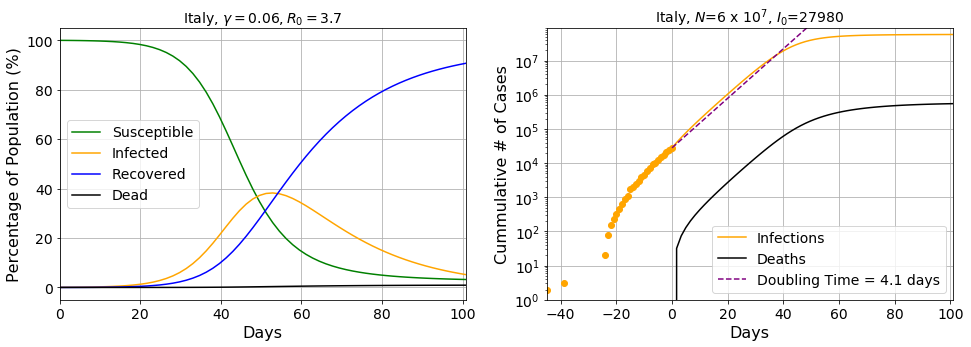

In [6]:
country = select_country('Italy')
f = plottage(country,RK3(country))


#### Results for Italy: 

The doubling rate means $R_0$ there is 3.9. The infection continues growing exponentially for one more month before peaking at 40% infected, then subsiding. 3% of the population escape the contagion. 500,000 deaths. 

Now moving on to S. Korea.

S. Korea
48
48
Parameters for: S. Korea
Basic reproduction number R0 = 1.3
Doubling time = 45.77853863015265  days
Infection rate beta = 0.08
Current cummulative infections= 8320
End of simulation at t = 543 days 

Percentage of people who avoided infection, S= 68 %
Percentage of infected, I= 1 %
Percentage of removed, R= 31 %

Percentage infected at peak of epidemics:  2 % 

Total number of deaths = 156336


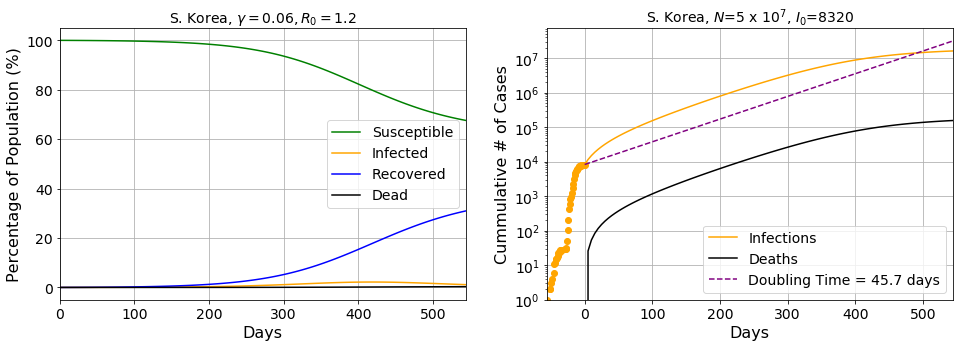

In [7]:
country = select_country('S. Korea')
f = plottage(country,RK3(country))

#### Results for S. Korea 

S. Korea infection control pushed the doubling rate to 29 days, that is, it brought $R_0$ to 1.3. That's much better. But unless controlled and a vaccine developed, that's still 200,000 deaths one year from now.

Next, results for Sweden. 


Parameters for: Sweden
Basic reproduction number R0 = 4.7
Doubling time = 3.133464663430907  days
Infection rate beta = 0.28
Current cummulative infections= 1121
End of simulation at t = 100 days 

Percentage of people who avoided infection, S= 1 %
Percentage of infected, I= 4 %
Percentage of removed, R= 95 %

Percentage infected at peak of epidemics:  45 % 

Total number of deaths = 95037


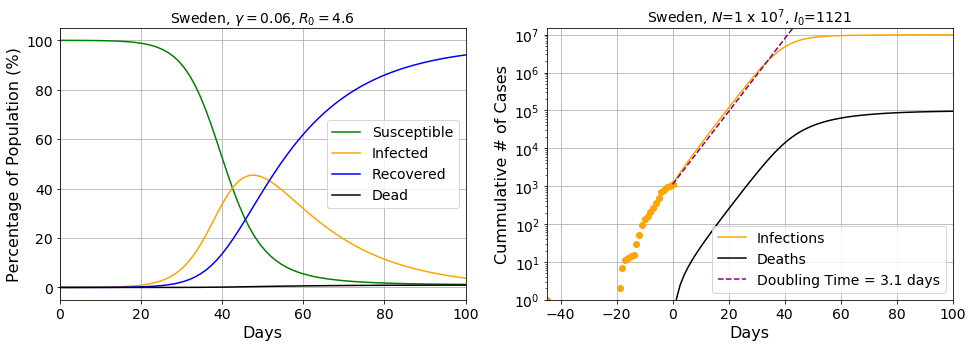

In [8]:
country = select_country('Sweden')
f = plottage(country,RK3(country))

#### Results for Sweden

At the current rate, Sweden is looking at 100,000 dead, with the epidemics peaking in early May, with 47% of the population infected at the same time. Not even a Scandinavian health system can cope with this massive number of sick. 

Next let's look at a country with a much less humane health care system, the United States. 

Parameters for: USA
Basic reproduction number R0 = 5.7
Doubling time = 2.4684760175831055  days
Infection rate beta = 0.34
Current cummulative infections= 4600
End of simulation at t = 100 days 

Percentage of people who avoided infection, S= 0 %
Percentage of infected, I= 3 %
Percentage of removed, R= 96 %

Percentage infected at peak of epidemics:  51 % 

Total number of deaths = 3085146


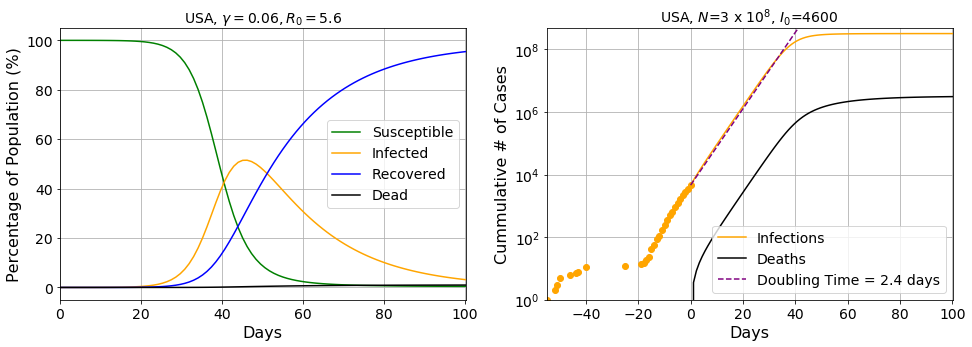

In [9]:
country = select_country('USA')
f = plottage(country,RK3(country))

#### Results for the USA

The results look just like Sweden, since they have a similar doubling time (2.4 vs 2.9) and similar percentage of initially infected people. 

The USA is behind Italy and S. Korea in the quarantine, the doubling rate of 2.4 days here translates into $R_0=5.8$. At the current rate we have 40 days of exponential growth, peaking at 50% of the population infected by early May, like Sweden. Unlike Sweden, the population is much higher. That number of infected people means the death toll in the USA is 3 million.

In the US the infection is just starting (less than 0.0005% of the population currently infected). Now look what happens if we take the same measures S. Korea took, i.e., bringing $R_0$ to 1.3 through social distancing and mass testing. 

Next we look at Brazil. 


Parameters for: Brazil
Basic reproduction number R0 = 5.9
Doubling time = 2.3423481562813677  days
Infection rate beta = 0.36
Current cummulative infections= 234
End of simulation at t = 100 days 

Percentage of people who avoided infection, S= 0 %
Percentage of infected, I= 5 %
Percentage of removed, R= 95 %

Percentage infected at peak of epidemics:  53 % 

Total number of deaths = 1902063


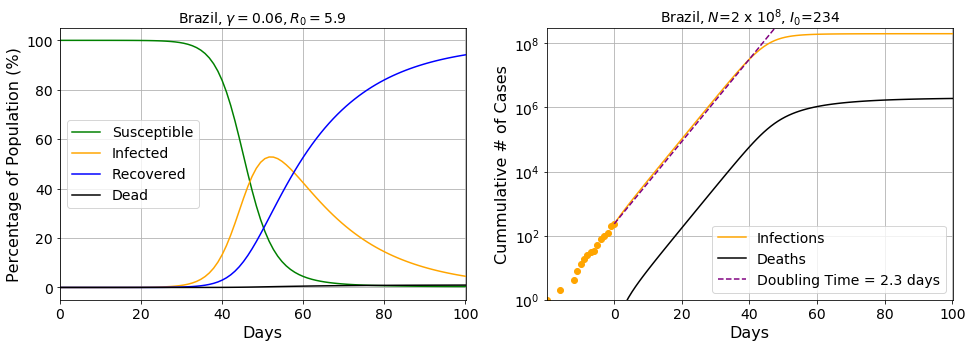

In [10]:
#country = select_country('USA with Korea R0')
country = select_country('Brazil')
f = plottage(country,RK3(country))

### Results for Brazil

The epidemics in Brazil is starting at a very fast pace, climbing with a doubling time of 2.3 days. With data from March 16th the prediction is that the first death should occur in the next few days. Indeed the day after the first death hit the news. The peak of the epidemics should be 50 days from now, in early to mid-May, peaking at 50% of the population infected, and leaving 2 million dead. Without vaccine or treatment, only social distancing can avoid this. 

#### Effect of social distancing in the USA

If the US takes the same level of precautions as S. Korea did, it will mean less than 1000 deaths in the same period (100 days). In a year, that would still mean 100,000 fatalities. Hopefully before then we can find out how to control it similarly to China (770 days doubling time and effectively controlled).



### Conclusions

This is the result of only a few hours of learning about modeling epidemiology; I do not claim the model is accurate. WHO is using a similar base model but with much more sophistication such as incubation period, transport between populations, birth and death rates, introduction of virus by the animal source, etc. For instance, $\beta$, the infection rate, depends on parameters of the population as well, like mobility. As such, it varies spatially. There's this 2D model here, applied to a city (Yerevan). 

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2

And here a 1D model solving for the populations of the animal vectors (presumably bats and including unidentified 'hosts') and people (BHRP model, for bats-hosts-reservoir-people). 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3


Still, the toy model in this notebook gives a good insight on the dynamics of the epidemics, and how social distancing works on stalling it and reducing the infection and death rate. 

# Stay home, folks. Reduce that $R_0$. Let's bring it under 1.




### References 

More on the model can be found here, and references therein. 

https://idpjournal.biomedcentral.com/articles/10.1186/s40249-020-00640-3

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2
    